# Title : Client Churn Prediction for Interconnect Telecom

## Introduction : 
The telecom operator Interconnect would like to be able to forecast their churn of clients. If it's discovered that a user is planning to leave, they will be offered promotional codes and special plan options. Interconnect's marketing team has collected some of their clientele's personal data, including information about their plans and contracts.

Interconnect's services

Interconnect mainly provides two types of services:
- Landline communication - The telephone can be connected to several lines simultaneously.
- Internet - The network can be set up via a telephone line (DSL, digital subscriber line) or through a fiber optic cable.
Some other services the company provides include:
* Internet security: antivirus software (DeviceProtection) and a malicious website blocker (OnlineSecurity)
* A dedicated technical support line (TechSupport)
* Cloud file storage and data backup (OnlineBackup)
* TV streaming (StreamingTV) and a movie directory (StreamingMovies)

The clients can choose either a monthly payment or sign a 1- or 2-year contract. They can use various payment methods and receive an electronic invoice after a transaction.

### Business Problem Statement : 
Interconnect wants to forecast the client churn.
### Business Value : 
Interconnect wants to forecast client churn in order to proactively retain customers by offering promotions or customized plans.
### Objectives :
    - Predict if a customer is at risk of leaving
    - Use model predictions to support market
    - Primary Key Performance Indicator : Maximize AUC ROC
    - Secondary Key Performance Indicator : Maintain high ACCURACY for stakeholder interpretability.

## Data Understanding:

Objectives:
- Load the dataset
- Explore the data
  
Available datasets from different sources:
- contract.csv — contract information
- personal.csv — the client's personal data
- internet.csv — information about Internet services
- phone.csv — information about telephone services
In each file, the column customerID contains a unique code assigned to each client.
The contract information is valid as of February 1, 2020.


In [59]:
# Import libraries
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
import lightgbm as lgb
from sklearn.metrics import roc_curve, auc


In [2]:
# Load  dataset
df_contract = pd.read_csv('/datasets/final_provider/contract.csv')
display(df_contract)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65
...,...,...,...,...,...,...,...,...
7038,6840-RESVB,2018-02-01,No,One year,Yes,Mailed check,84.80,1990.5
7039,2234-XADUH,2014-02-01,No,One year,Yes,Credit card (automatic),103.20,7362.9
7040,4801-JZAZL,2019-03-01,No,Month-to-month,Yes,Electronic check,29.60,346.45
7041,8361-LTMKD,2019-07-01,2019-11-01 00:00:00,Month-to-month,Yes,Mailed check,74.40,306.6


In [3]:
df_contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [4]:
df_contract['BeginDate'].value_counts().sort_index()

2013-10-01      3
2013-11-01      2
2013-12-01      3
2014-01-01      7
2014-02-01    366
             ... 
2019-10-01    237
2019-11-01    237
2019-12-01    220
2020-01-01    233
2020-02-01     11
Name: BeginDate, Length: 77, dtype: int64

The data stored above is  customers who started there connection from January 01, 2013 to February 01, 2020.

In [5]:
len(df_contract[df_contract['EndDate']=='No'])/len(df_contract['EndDate'])

0.7346301292063041

About 73.46% customers from above period leaves the service which means more than 25% customers are leaving. So we want to find out the major factors which affect the churn rate and how we can retain the customers.

The df_contract dataframe consists of 7043 rows and 8 columns. The columns are:

customerID - A unique identifier for each customer. It likely serves as the primary key.
BeginDate -The start date of the customer's subscription. Stored as a string but should be converted to datetime.
EndDate -The end date of the subscription. Could indicate churn if it differs from a "still active" stage. Also stored as a string.
Type - The type of subscription
PaperlessBilling-Indicates whether the customer opted for paperless billing (Yes/No). A binary categorical variable.
PaymentMethod -Method of payment (e.g., credit card, bank transfer, electronic check). Categorical variable.
MonthlyCharges-The amount charged to the customer monthly. This is a numerical feature.
TotalCharges-The total amount charged
Potential issues are Incorrect Data Types:

 - TotalCharges is an object type but should be numeric.
 - BeginDate and EndDate should be datetime, not object.

In [6]:
df_personal = pd.read_csv('/datasets/final_provider/personal.csv')
display(df_personal)

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No
...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes
7039,2234-XADUH,Female,0,Yes,Yes
7040,4801-JZAZL,Female,0,Yes,Yes
7041,8361-LTMKD,Male,1,Yes,No


In [7]:
df_personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


The DataFrame you’ve provided has 7,043 rows and 5 columns, representing personal data for customers.

customerID -Unique identifier for each customer. Used to link with other datasets.
gender - Customer’s gender.
SeniorCitizen - Indicates if the customer is a senior citizen: 0 = No, 1 = Yes. A binary numeric flag.
Partner - Indicates if the customer has a partner: Yes or No. A binary categorical variable.
Dependents - Indicates if the customer has dependents(Yes or No)


In [8]:
len(df_personal[df_personal['Dependents']=='Yes'])/len(df_personal['Dependents'])

0.2995882436461735

Is there any family plan improves the profit and deacrease the churn rate.

In [9]:
df_personal['gender'].value_counts()

Male      3555
Female    3488
Name: gender, dtype: int64

In the dataset, there are 3,555 male entries and 3,488 female entries, indicating a nearly balanced distribution between genders.

In [10]:
df_internet = pd.read_csv('/datasets/final_provider/internet.csv')
display(df_internet)

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No
...,...,...,...,...,...,...,...,...
5512,6840-RESVB,DSL,Yes,No,Yes,Yes,Yes,Yes
5513,2234-XADUH,Fiber optic,No,Yes,Yes,No,Yes,Yes
5514,4801-JZAZL,DSL,Yes,No,No,No,No,No
5515,8361-LTMKD,Fiber optic,No,No,No,No,No,No


In [11]:
df_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


The third DataFrame provided contains 5,517 rows and 8 columns, focused on internet service and additional digital features associated with customers.

customerID : Unique identifier for each customer. Used to link with other datasets.
InternetService : Type of internet service: values like DSL, Fiber optic
OnlineSecurity : Whether the customer subscribes to online security services (Yes, No)
OnlineBackup : Indicates if online backup service is included (Yes, No)
DeviceProtection : Whether the customer has device protection service (Yes, No)
TechSupport : Access to technical support service (Yes, No)
StreamingTV : Whether the customer streams TV through the provider (Yes, No)
StreamingMovies :Whether the customer streams movies through the provider (Yes, No)

In [12]:
df_internet['InternetService'].value_counts()

Fiber optic    3096
DSL            2421
Name: InternetService, dtype: int64

The dataset includes 3,096 entries using fiber optic connections and 2,421 using DSL. Fiber optic is the more common connection type, suggesting a higher adoption of faster internet service among users.

In [13]:
df_phone = pd.read_csv('/datasets/final_provider/phone.csv')
display(df_phone)

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes
...,...,...
6356,2569-WGERO,No
6357,6840-RESVB,Yes
6358,2234-XADUH,Yes
6359,8361-LTMKD,Yes


In [14]:
df_phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


This DataFrame contains 6,361 rows and 2 columns, providing data on whether customers have multiple phone lines as part of their service.

customerID : Unique identifier for each customer. Used for merging with other datasets.
MultipleLines : Indicates whether the customer has multiple phone lines (Yes, No)

In [15]:
len(df_phone[df_phone['MultipleLines']=='Yes'])/len(df_phone['MultipleLines'])

0.46706492689828644

From the above analysis, it is clear that 46.7% of customers have multiple lines and do customers with multiple lines have a higher churn rate compared to those with a single line, could there be underlying service or pricing issues driving this factor.

## Clarifying Questions

1. What are the key factors contributing to customer churn in our dataset?
2. Which features (e.g., contract, internet service, online security, online backup, device protection) are most strongly associated with higher churn rates?
3. Are customers with multiple lines more likely to churn than those with only one line?
4. Based on our churn drivers, what targeted strategies can we implement to improve customer retention?
5. What is the acceptable level of false positives in our churn prediction model, considering the marketing budget for retention offers and promotions?

## Proposed Work Plan
Our goal is to develop a model that can tell the user will leave the service and the steps to achieve that will be

1. Download the data
2. Explore the data to determine how to treat the data in the preprocessing
3. Perform preprocessing of data
      - Change column name to snakecase
      - Handle missing values, type conversions
      - Merge datasets on Customer ID
      - Define target variable (Churn=1 or 0)
4. Perform EDA to explore the data in depth
      - Determine churn Vs non churn
      - Examine is there any factors like gender, type etc affect the churn rate
      - Examine the class imbalace and verify that churn is the minority class
      - Visualize the correlation between different features
      - Examiner data quality issues like outliers
5. Feature Engineering
      - Feature extraction
      - Encoding categorical variables- One Hot Encoding
      - Normalize/Scale numerical features
6. Compare different models
      - Logistic Regression (baseline)
      - Random Forest / Gradient Boosting (XGBoost, LightGBM)
      - Hyperparameter tuning
      - Handle class imbalances
      - Evaluvate KPI AUC ROC and accuracy
7. Model Interpretation
      - Evaluvate different models and choose the model which obtain higher AUC ROC
8. Final Report


## Data Preparation :
Objectives:
- Merge datasets on Customer ID
- Handle missing values, type conversions
- Define target variable (Churn=1 or 0)

In [16]:
# Convert the name of columns into appropriate form
df_contract.columns = [re.sub(r'(?<!^)(?=[A-Z])', '_', column).lower().replace(' ', '_') for column in df_contract.columns]
print(df_contract.columns)

Index(['customer_i_d', 'begin_date', 'end_date', 'type', 'paperless_billing',
       'payment_method', 'monthly_charges', 'total_charges'],
      dtype='object')


In [17]:
# Convert the name of columns into appropriate form
df_personal.columns = [re.sub(r'(?<!^)(?=[A-Z])', '_', column).lower().replace(' ', '_') for column in df_personal.columns]
print(df_personal.columns)

Index(['customer_i_d', 'gender', 'senior_citizen', 'partner', 'dependents'], dtype='object')


In [18]:
# Convert the name of columns into appropriate form
df_internet.columns = [re.sub(r'(?<!^)(?=[A-Z])', '_', column).lower().replace(' ', '_') for column in df_internet.columns]
print(df_internet.columns)

Index(['customer_i_d', 'internet_service', 'online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_t_v',
       'streaming_movies'],
      dtype='object')


In [19]:
# Convert the name of columns into appropriate form
df_phone.columns = [re.sub(r'(?<!^)(?=[A-Z])', '_', column).lower().replace(' ', '_') for column in df_phone.columns]
print(df_phone.columns)

Index(['customer_i_d', 'multiple_lines'], dtype='object')


In [20]:
# Convert  dates dtype to datetime
df_contract['begin_date'] = pd.to_datetime(df_contract['begin_date'])

In [21]:
# Create churn target column: 1 = churned, 0 = not churned
df_contract['churn'] = (df_contract['end_date'] != 'No').astype(int)
# Drop end date
df_contract.drop(columns=['end_date'], inplace=True)

In [22]:
# Convert total charges to numeric type
df_contract['total_charges'] = pd.to_numeric(df_contract['total_charges'], errors='coerce')
# Check for NaNs created by coercion:
df_contract['total_charges'] .isna().sum()

11

In [23]:
# Drop missing columns
df_contract = df_contract.dropna(subset=['total_charges'])

In [24]:
# Check for missing values
df_contract.isnull().sum()

customer_i_d         0
begin_date           0
type                 0
paperless_billing    0
payment_method       0
monthly_charges      0
total_charges        0
churn                0
dtype: int64

In [25]:
#Check for duplicate values
df_contract.duplicated().sum()

0

In [26]:
# Check for missing values
df_personal.isnull().sum()

customer_i_d      0
gender            0
senior_citizen    0
partner           0
dependents        0
dtype: int64

In [27]:
#Check for duplicate values
df_personal.duplicated().sum()

0

In [28]:
# Check for missing values
df_internet.isnull().sum()

customer_i_d         0
internet_service     0
online_security      0
online_backup        0
device_protection    0
tech_support         0
streaming_t_v        0
streaming_movies     0
dtype: int64

In [29]:
#Check for duplicate values
df_internet.duplicated().sum()

0

In [30]:
# Check for missing values
df_phone.isnull().sum()

customer_i_d      0
multiple_lines    0
dtype: int64

In [31]:
#Check for duplicate values
df_phone.duplicated().sum()

0

In [32]:
# Merge the dataframe
df = df_contract.merge(df_personal, on='customer_i_d', how='left') \
                       .merge(df_internet, on='customer_i_d', how='left') \
                       .merge(df_phone, on='customer_i_d', how='left')
display(df)

,customer_i_d,begin_date,type,paperless_billing,payment_method,monthly_charges,total_charges,churn,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_t_v,streaming_movies,multiple_lines
0,7590-VHVEG,2020-01-01,Month-to-month,Yes,Electronic check,29.85,29.85,0,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,One year,No,Mailed check,56.95,1889.50,0,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,Month-to-month,Yes,Mailed check,53.85,108.15,1,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,One year,No,Bank transfer (automatic),42.30,1840.75,0,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,2019-09-01,Month-to-month,Yes,Electronic check,70.70,151.65,1,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7027,6840-RESVB,2018-02-01,One year,Yes,Mailed check,84.80,1990.50,0,Male,0,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,Yes
7028,2234-XADUH,2014-02-01,One year,Yes,Credit card (automatic),103.20,7362.90,0,Female,0,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Yes
7029,4801-JZAZL,2019-03-01,Month-to-month,Yes,Electronic check,29.60,346.45,0,Female,0,Yes,Yes,DSL,Yes,No,No,No,No,No,NaN
7030,8361-LTMKD,2019-07-01,Month-to-month,Yes,Mailed check,74.40,306.60,1,Male,1,Yes,No,Fiber optic,No,No,No,No,No,No,Yes


In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7031
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_i_d       7032 non-null   object        
 1   begin_date         7032 non-null   datetime64[ns]
 2   type               7032 non-null   object        
 3   paperless_billing  7032 non-null   object        
 4   payment_method     7032 non-null   object        
 5   monthly_charges    7032 non-null   float64       
 6   total_charges      7032 non-null   float64       
 7   churn              7032 non-null   int64         
 8   gender             7032 non-null   object        
 9   senior_citizen     7032 non-null   int64         
 10  partner            7032 non-null   object        
 11  dependents         7032 non-null   object        
 12  internet_service   5512 non-null   object        
 13  online_security    5512 non-null   object        
 14  online_b

In [34]:
# Check for missing values
df.isnull().sum()

customer_i_d            0
begin_date              0
type                    0
paperless_billing       0
payment_method          0
monthly_charges         0
total_charges           0
churn                   0
gender                  0
senior_citizen          0
partner                 0
dependents              0
internet_service     1520
online_security      1520
online_backup        1520
device_protection    1520
tech_support         1520
streaming_t_v        1520
streaming_movies     1520
multiple_lines        680
dtype: int64

In [35]:
# Fill missing values
df.fillna('missing', inplace=True)

In [36]:
#Recheck for missing values
df.isnull().sum()

customer_i_d         0
begin_date           0
type                 0
paperless_billing    0
payment_method       0
monthly_charges      0
total_charges        0
churn                0
gender               0
senior_citizen       0
partner              0
dependents           0
internet_service     0
online_security      0
online_backup        0
device_protection    0
tech_support         0
streaming_t_v        0
streaming_movies     0
multiple_lines       0
dtype: int64

In [37]:
# Check for duplicates
df.duplicated().sum()

0

After merging the datasets on Customer ID, the combined data provides a comprehensive view of each customer’s information. Missing values were carefully handled to ensure data quality and integrity, including appropriate imputation or removal where necessary. Data types were converted to their correct formats (e.g., dates to datetime) to facilitate accurate analysis.
The target variable, churn, was defined as a binary indicator, with 1 representing customers who have churned and 0 representing those who have stayed. This clear definition of the target enables the application of predictive modeling techniques to understand and forecast customer churn behavior effectively.

## Exploratory data analysis:
Objectives
- Determine churn Vs non churn
- Examine is there any factors like gender, type etc affect the churn rate
- Examine the class imbalace and expect that churn is the minority class
- Visualize the correlation between different services

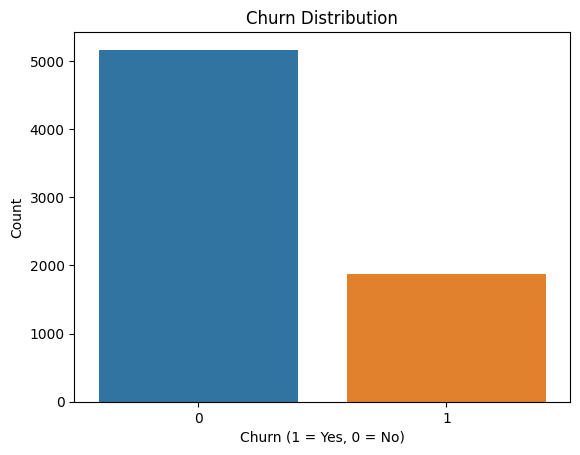

In [38]:
# Churn Distribution: Plot active Vs churned customers
sns.countplot(data=df, x='churn')
plt.title('Churn Distribution')
plt.xlabel('Churn (1 = Yes, 0 = No)')
plt.ylabel('Count')
plt.show()

In [39]:
df['churn'].value_counts()

0    5163
1    1869
Name: churn, dtype: int64

In [40]:
#Percentage Rate
churn_rate = df['churn'].mean()
print(f" Churn Rate: {churn_rate:.2%}")

 Churn Rate: 26.58%


The dataset contains 7,032 customers, of which 1,869 have churned (labeled as 1) and 5,163 have remained (0). This results in a churn rate of 26.58%, confirming that churners represent the minority class in the dataset. Also, the churn rate indicates that approximately one in four customers discontinue the service. Understanding and predicting this churn behavior is critical for developing effective retention strategies.

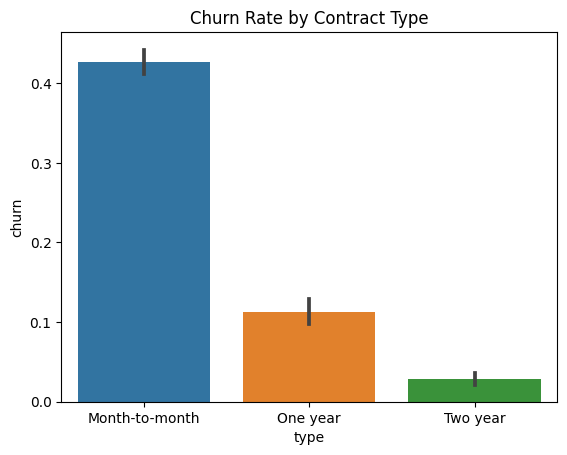

type
Month-to-month    42.709677
One year          11.277174
Two year           2.848665
Name: churn, dtype: float64


In [41]:
# Churn rate by contract type
sns.barplot(data=df, x='type', y='churn')
plt.title('Churn Rate by Contract Type')
plt.show()
# Churn rate(%) by contract type
churn_rate = df.groupby('type')['churn'].mean() * 100
print(churn_rate)

From the above barplot and results it is clear that,the churn rates vary significantly across contract types:

- Customers on Month-to-month contracts have the highest churn rate at approximately 42.7%, indicating a large proportion of these customers discontinue service relatively quickly.
- Those with One-year contracts show a much lower churn rate of about 11.3%, suggesting better customer retention.
- Customers with Two-year contracts exhibit the lowest churn rate at around 2.8%, reflecting strong loyalty or contract commitment over a longer term.

These differences highlight the impact of contract length on customer churn, with shorter-term contracts associated with higher churn risk. This insight can guide retention efforts to focus on month-to-month customers who are most likely to leave.

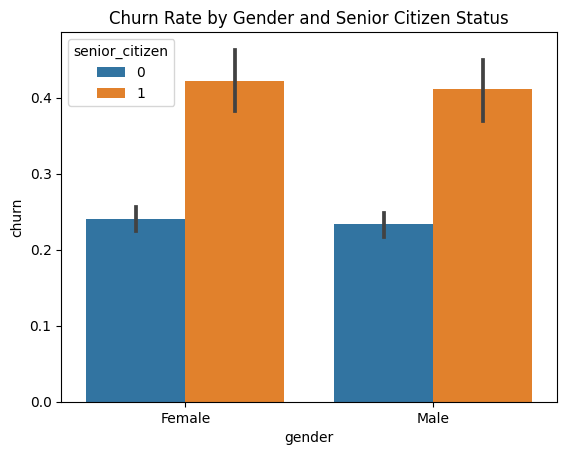

In [42]:
# Churn rate by gender type and senior citizen
sns.barplot(data=df, x='gender', y='churn', hue='senior_citizen')
plt.title('Churn Rate by Gender and Senior Citizen Status')
plt.show()

The grouped barplot illustrates the churn rate (as a percentage) segmented by gender and senior citizen status. Each gender category (Male and Female) is further divided into two bars representing whether the customer is a senior citizen (1) or not (0). From the visualization, we can observe:

- Churn rates vary slightly between genders, but the difference is not substantial.
- Senior citizens consistently show a higher churn rate across both gender groups.
- For both males and females, non-senior customers have a lower churn rate, suggesting age-related factors may contribute to churn behavior.

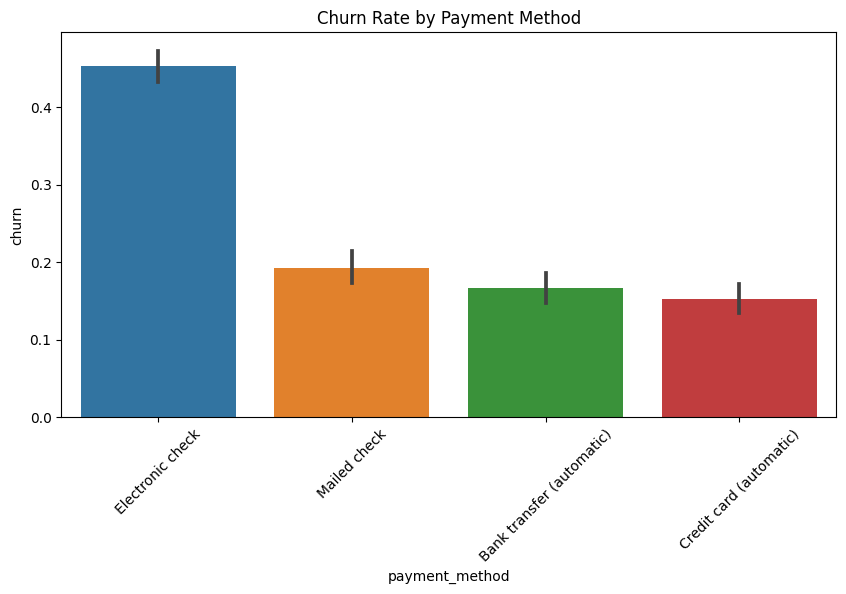

payment_method
Bank transfer (automatic)    16.731518
Credit card (automatic)      15.253123
Electronic check             45.285412
Mailed check                 19.201995
Name: churn, dtype: float64


In [43]:
# Churn rate by payment method
plt.figure(figsize=(10,5))
sns.barplot(data=df, x='payment_method', y='churn')
plt.title('Churn Rate by Payment Method')
plt.xticks(rotation=45)
plt.show()
# Churn rate(%) by payment method
churn_rate = df.groupby('payment_method')['churn'].mean() * 100.
print(churn_rate)

From the above barplot and results it is clear that, the churn rate varies significantly across different payment methods, indicating that billing preferences may influence customer retention:

- Customers using Electronic check have the highest churn rate at 45.29%, which is substantially above average.
- Those using Mailed check have a moderate churn rate of 19.20%.
- In contrast, automatic payment methods such as Bank transfer (16.73%) and Credit card (15.25%) are associated with the lowest churn rates.

This pattern implies that customers who opt for automatic payments are more likely to remain subscribed, possibly due to increased convenience or reduced likelihood of service interruption. It also highlights Electronic check users as a high-risk segment for churn, meriting further investigation or targeted retention efforts.

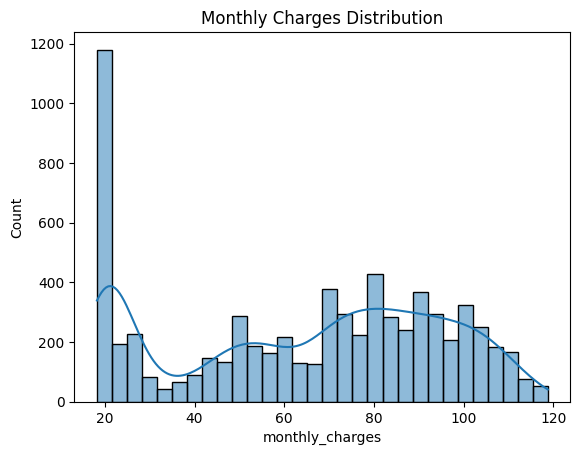

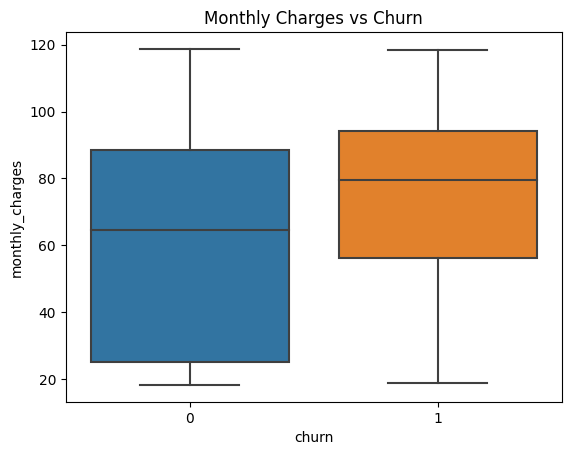

In [44]:
# Distribution of monthly charges
sns.histplot(df['monthly_charges'], bins=30, kde=True)
plt.title('Monthly Charges Distribution')
plt.show()
# Boxplot of Monthly Charges vs Churn
sns.boxplot(data=df, x='churn', y='monthly_charges')
plt.title('Monthly Charges vs Churn')
plt.show()

The histogram with a KDE curve shows that monthly charges are not normally distributed. The plot indicates that while most customers pay a moderate monthly fee, a smaller portion are on higher-priced plans, which could be due to premium services or add-ons. The boxplot compares the distribution of monthly_charges between churned (churn = 1) and non-churned (churn = 0) customers. Key observations are:

- Median monthly charges are higher for churned customers.
- Non-churned customers have lower and more tightly clustered monthly charges. This suggests a positive correlation between higher monthly charges and churn, possibly indicating price sensitivity among customers or dissatisfaction with value received at higher price points.


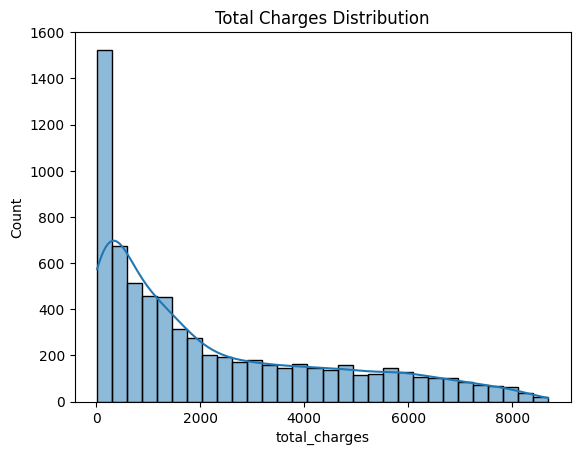

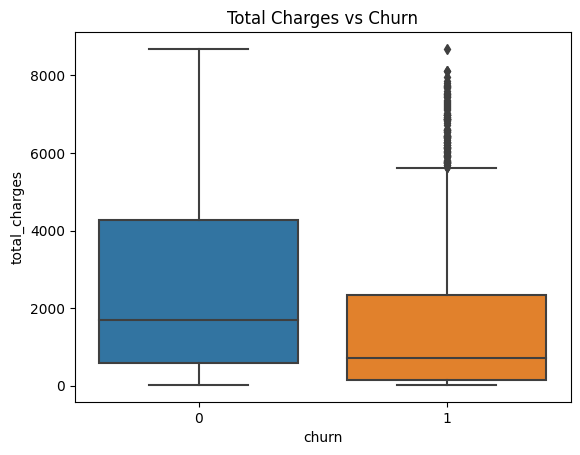

In [45]:
# Distribution of total charges
sns.histplot(df['total_charges'], bins=30, kde=True)
plt.title('Total Charges Distribution')
plt.show()
# Boxplot of Monthly Charges vs Churn
sns.boxplot(data=df, x='churn', y='total_charges')
plt.title('Total Charges vs Churn')
plt.show()

The histogram of total_charges shows a right-skewed distribution, with most customers having relatively low to moderate total charges and a long tail extending toward higher values. The KDE curve confirms the skewness, highlighting a high concentration of customers at the lower end of total charges. The boxplot reveals clear differences in total charges between churned (churn = 1) and non-churned (churn = 0) customers:

- The median total charges for churned customers is significantly lower than for those who stayed.
- Churned customers also show a narrower interquartile range, indicating less variation in total charges
- Non-churned customers have higher and more variable total charges, consistent with longer tenure and continued service usage.

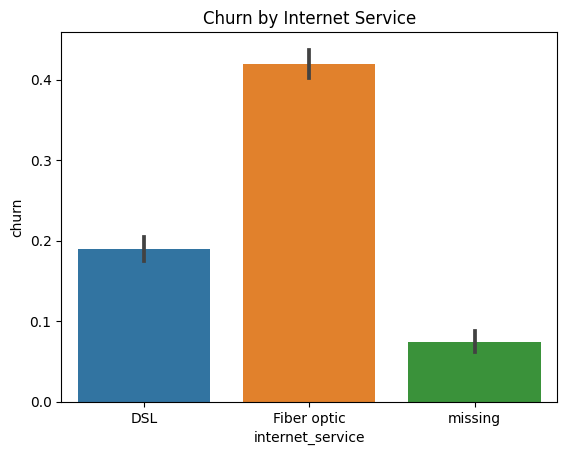

internet_service
DSL            18.998344
Fiber optic    41.892765
missing         7.434211
Name: churn, dtype: float64


In [46]:
# Churn rate by internet service
sns.barplot(data=df, x='internet_service', y='churn')
plt.title('Churn by Internet Service')
plt.show()
# Churn rate(%) by internet service
churn_rate = df.groupby('internet_service')['churn'].mean() * 100.
print(churn_rate)

The churn rate varies notably across different types of internet services. These differences highlight that internet service type is a strong predictor of churn.:

- Fiber optic customers show the highest churn rate at 41.89%, indicating a significantly elevated risk of service cancellation. This may suggest issues related to pricing, performance expectations, or service satisfaction among high-speed users.
- DSL customers have a lower churn rate of 18.99%, suggesting relatively higher satisfaction compared to fiber optic

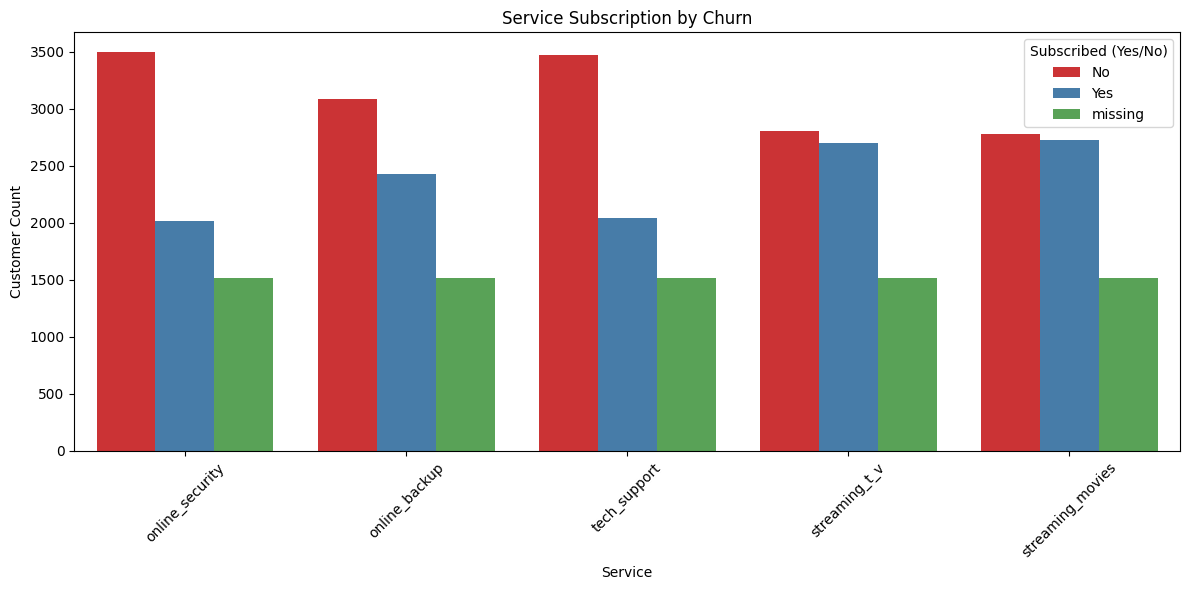

In [47]:
# Different services Vs churn
services = ['online_security', 'online_backup', 'tech_support', 'streaming_t_v', 'streaming_movies']

df_melted = df.melt(id_vars='churn', value_vars=services,
                    var_name='Service', value_name='Subscribed')

# Plot
plt.figure(figsize=(12, 6))
sns.countplot(data=df_melted, x='Service', hue='Subscribed', palette='Set1', dodge=True)
plt.title('Service Subscription by Churn')
plt.xlabel('Service')
plt.ylabel('Customer Count')
plt.xticks(rotation=45)
plt.legend(title='Subscribed (Yes/No)')
plt.tight_layout()
plt.show()

The plot shows customer counts for each service, broken down by whether the service was subscribed to (Yes or No) and whether the customer churned.

- For online security, online backup, and tech support, churn is noticeably higher among customers who did not subscribe to these services. This implies that lack of engagement with support and security-related services may correlate with higher churn.
- In contrast, for streaming TV and streaming movies, the number of churned customers is almost equal among those who did subscribe, indicating that these entertainment services are not a big factor for leaving the connection.

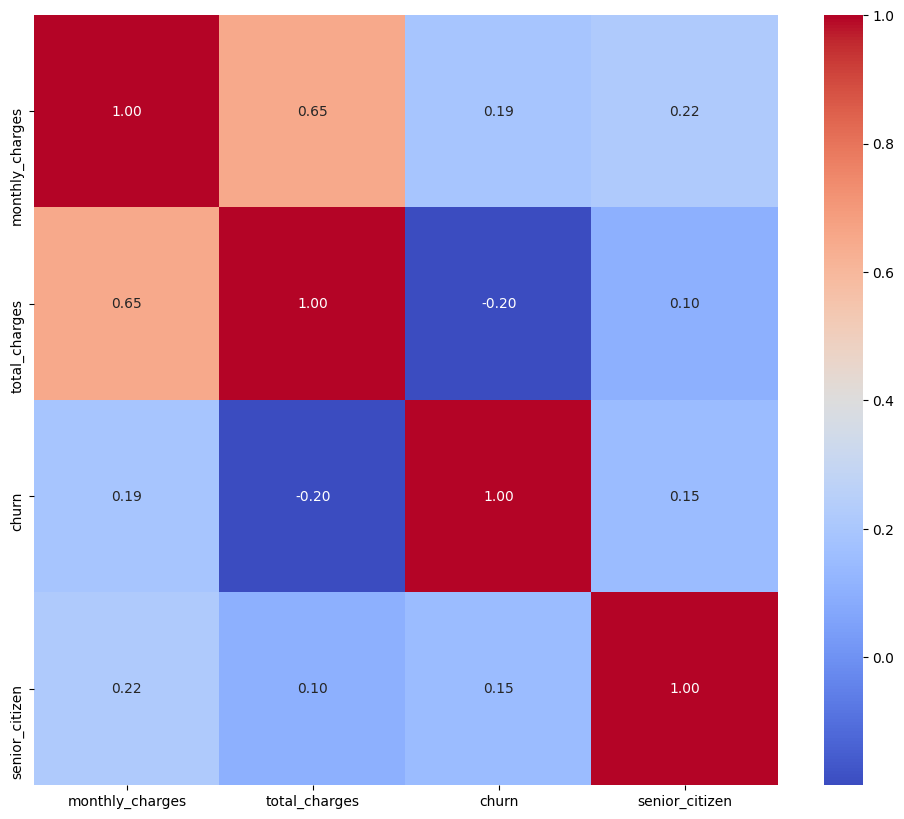

In [48]:
#Corelation heatmap displays corelation between quantitative features:
plt.figure(figsize=(12,10))
sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.show()

The correlation heatmap provides a visual representation of the linear relationships between the quantitative (numerical) features in the dataset. Each cell in the heatmap shows the Pearson correlation coefficient between two variables, ranging from -1 (perfect negative correlation) to +1 (perfect positive correlation), with values near 0 indicating no linear correlation.

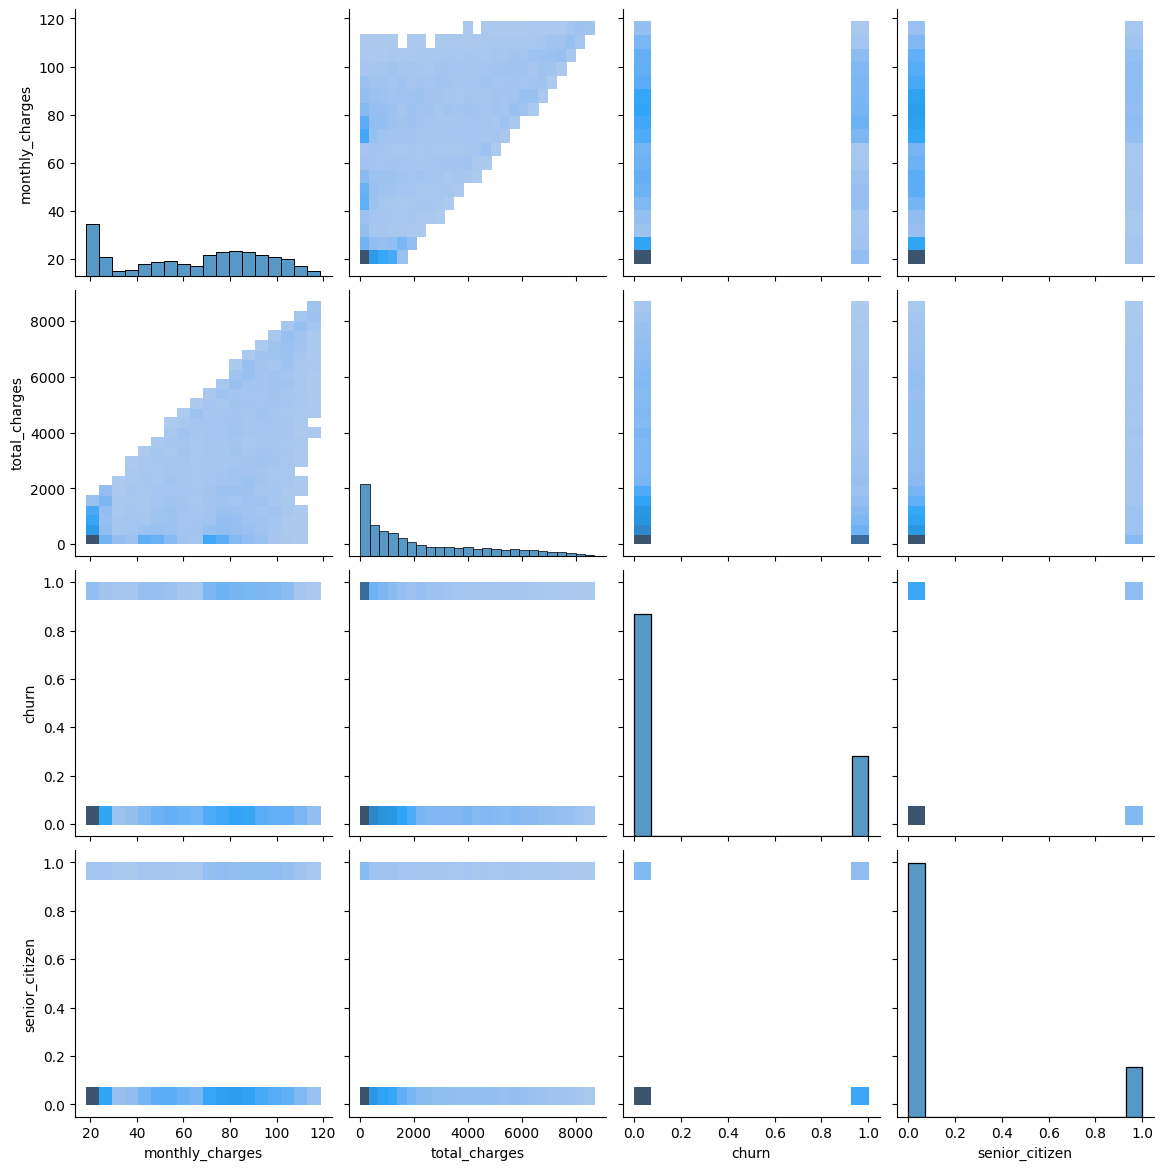

In [49]:
#Pair plot
g = sns.pairplot(df, kind='hist')
g.fig.set_size_inches(12, 12)

This histogram-based pair plot provides a quick overview of the distributions of all numeric variables, making it useful for spotting:Skewness, Outliers, Data range, Imbalance in binary features etc.

The EDA phase provided comprehensive insights into the customer dataset and identified key patterns and variables associated with churn:
- Approximately 26.58% of customers have churned, confirming a moderate class imbalance, with churn being the minority class.This imbalance should be addressed during modeling (e.g., using class weights or resampling).
- Senior citizens have a higher churn rate across both genders.
- Gender alone does not show significant difference in churn behavior.
- Month-to-month contracts have the highest churn rate (42.7%), while two-year contracts have the lowest (2.8%), indicating longer commitments reduce churn.
- Electronic check users have the highest churn (45.3%), while automatic payments (bank transfer/credit card) are linked with much lower churn rates (15–20%).
- Customers not subscribed to online security, tech support, or online backup are more likely to churn, suggesting these services contribute to retention.
- The median total charges for churned customers is significantly lower than for those who stayed.
- Median monthly charges are higher for churned customers.

## Feature Engineering

Objectives:
- Feature extraction
- Encoding categorical variables- One Hot Encoding
- Normalize/Scale numerical features

In [50]:
#Find tenure months from begin date
reference_date = pd.to_datetime('2020-02-01')
df['tenure_months'] = (reference_date - df['begin_date']).dt.days // 30

<div class="alert alert-block alert-success">
<b>Reviewer's comment</b> Good job deriving tenure. 
<a class="tocSkip">

In [51]:
# Drop unneeded columns
df.drop(['customer_i_d', 'begin_date'], axis=1, inplace=True)

In [52]:
# Convert SeniorCitizen to categorical
df['senior_citizen'] = df['senior_citizen'].astype(str)

In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7031
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   type               7032 non-null   object 
 1   paperless_billing  7032 non-null   object 
 2   payment_method     7032 non-null   object 
 3   monthly_charges    7032 non-null   float64
 4   total_charges      7032 non-null   float64
 5   churn              7032 non-null   int64  
 6   gender             7032 non-null   object 
 7   senior_citizen     7032 non-null   object 
 8   partner            7032 non-null   object 
 9   dependents         7032 non-null   object 
 10  internet_service   7032 non-null   object 
 11  online_security    7032 non-null   object 
 12  online_backup      7032 non-null   object 
 13  device_protection  7032 non-null   object 
 14  tech_support       7032 non-null   object 
 15  streaming_t_v      7032 non-null   object 
 16  streaming_movies   7032 

In [54]:
#Features and target
features =df.drop('churn', axis=1)
target = df['churn']

The churn column is selected as the target, while all other columns are treated as features.

In [55]:
#Numerical and categorical features
numerical =['monthly_charges', 'total_charges','tenure_months']
categorical = [col for col in features.columns if col not in numerical]

In [56]:
#Split the data 
features_train, features_test, target_train, target_test = train_test_split(features, target, stratify=target, test_size=0.25, random_state=42)

We then split the dataset into training and test sets using train_test_split, maintaining the distribution of the target variable with stratification (stratify=target), and setting aside 25% of the data for testing.

In [57]:
# Preprocessing pipeline
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numerical),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical)
])

The ColumnTransformer is a powerful tool from scikit-learn that allows different preprocessing steps to be applied to different subsets of features within a single pipeline. This is especially useful when working with datasets that contain both numerical and categorical data.
In our case:
- Numerical features are standardized using StandardScaler, which transforms them to have a mean of 0 and standard deviation of 1. This ensures that numerical values are on a comparable scale, which can improve model performance and convergence.
- Categorical features are transformed using OneHotEncoder, converting each category into a binary vector. The handle_unknown='ignore' parameter allows the encoder to gracefully handle categories that may appear in the data.

## Modelling

Objectives:
- Compare different models like:
  
      * Logistic Regression(Sanity check)
      * Decision Tree Classifier
      * Random Forest Classifier
      * XGBClassifier
      * CatBoostClassifier
      * LightGBM Classifier
- Evaluvate on AUC ROC as first KPI
- Track Accuracy of each model     

In [61]:
# Logistic Regression Model
# Create pipeline with Logistic Regression
lr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('clf', LogisticRegression(solver='liblinear', max_iter=1000))
])

# Define hyperparameter distribution
lr_param = {
    'clf__C': [0.01, 0.1, 1, 10, 100],
    'clf__penalty': ['l1', 'l2']
}

# RandomizedSearchCV 
lr_search = RandomizedSearchCV(lr_pipeline,
    param_distributions=lr_param,
    n_iter=10,  
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1,
    random_state=42
)

# Fit randomized search
lr_search.fit(features_train, target_train)

# Best model from search
best_model = lr_search.best_estimator_

# Predictions
lr_pred = best_model.predict(features_test)
lr_proba = best_model.predict_proba(features_test)[:, 1]

# Evaluation
print("Best Hyperparameters:",lr_search.best_params_)
print("AUC-ROC Score:", roc_auc_score(target_test, lr_proba))
print("Accuracy Score:", accuracy_score(target_test, lr_pred))
print("Confusion Matrix:\n", confusion_matrix(target_test, lr_pred))

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Hyperparameters: {'clf__penalty': 'l2', 'clf__C': 10}
AUC-ROC Score: 0.8307986272945462
Accuracy Score: 0.7997724687144482
Confusion Matrix:
 [[1146  145]
 [ 207  260]]


After performing hyperparameter tuning using randomized search with 5-fold cross-validation over 10 candidate parameter combinations (a total of 50 fits), the best logistic regression model was identified with the following hyperparameters:
- Penalty: 'l2'
- C (Inverse of regularization strength): 10

Performance Metrics on the Test Set:
- AUC-ROC Score of 0.831 indicates the model has a strong ability to distinguish between the positive (churn) and negative classes.
- Accuracy Score of 0.800 indicates that the model correctly predicted approximately 80% of the test instances.
- The confusion matrix shows that
  
      - True Negatives (TN): 1146 customers correctly predicted as non-churners
      - False Positives (FP): 145 customers incorrectly predicted as churners
      - False Negatives (FN): 207 churners missed by the model
      - True Positives (TP): 260 churners correctly identified

<div class="alert alert-block alert-success">
<b>Reviewer's comment</b> Very good commentary on the results we are seeing!
<a class="tocSkip"></


In [62]:
# DecisionTree Classifier Modelling
# Define the pipeline
dt_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('clf', DecisionTreeClassifier(random_state=42))
])

# Define hyperparameter 
dt_params = {
    'clf__max_depth': [3, 5, 10, None],
    'clf__min_samples_split': [2, 5, 10],
    'clf__criterion': ['gini', 'entropy']
}

# Use RandomizedSearchCV 
dt_search = RandomizedSearchCV(
    dt_pipeline,
    param_distributions=dt_params,
    n_iter=10,  
    scoring='roc_auc',
    cv=5,
    n_jobs=-1,
    verbose=1,
    random_state=42
)

# Fit the randomized search
dt_search.fit(features_train, target_train)

# Get the best estimator
dt_best = dt_search.best_estimator_

# Predict and evaluate
dt_pred = dt_best.predict(features_test)
dt_proba = dt_best.predict_proba(features_test)[:, 1]

print("DT Best Params:", dt_search.best_params_)
print("DT AUC-ROC:", roc_auc_score(target_test, dt_proba))
print("DT Accuracy:", accuracy_score(target_test, dt_pred))
print("Confusion Matrix:\n", confusion_matrix(target_test, dt_pred))

Fitting 5 folds for each of 10 candidates, totalling 50 fits
DT Best Params: {'clf__min_samples_split': 10, 'clf__max_depth': 5, 'clf__criterion': 'gini'}
DT AUC-ROC: 0.8611388014868212
DT Accuracy: 0.8191126279863481
Confusion Matrix:
 [[1171  120]
 [ 198  269]]


A Decision Tree Classifier was trained using RandomizedSearchCV to optimize hyperparameters. The randomized search evaluated 10 candidate parameter combinations using 5-fold cross-validation, resulting in a total of 50 fits.

Best Hyperparameters Found:
- Criterion: 'gini' (used to measure the quality of a split)
- Max Depth: 5 (limits the maximum depth of the tree to prevent overfitting)
- Min Samples Split: 10 (the minimum number of samples required to split an internal node)

Performance Metrics on the Test Set:
- AUC-ROC Score of 0.861 indicates excellent discriminative power between the churn and non-churn classes.
- Accuracy Score of 0.819 means that the model correctly classified ~82% of the instances in the test set.
- The confusion matrix shows that

      - True Negatives (TN): 1171 non-churners correctly predicted
      - False Positives (FP): 120 non-churners incorrectly predicted as churners
      - False Negatives (FN): 198 churners missed by the model
      - True Positives (TP): 269 churners correctly identified

In [63]:
# RandomForest Classifier Modelling
# Define the pipeline
rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('clf', RandomForestClassifier(random_state=42))
])

# Define hyperparameter distribution
rf_params = {
    'clf__n_estimators': [100, 200],
    'clf__max_depth': [5, 10, None],
    'clf__min_samples_split': [2, 5],
    'clf__max_features': ['sqrt', 'log2']
}

# Use RandomizedSearchCV 
rf_search = RandomizedSearchCV(rf_pipeline, rf_params, scoring='roc_auc', n_iter=10, cv=5, n_jobs=-1, verbose=1)
# Fit the randomized search
rf_search.fit(features_train, target_train)

# Get the best estimator
rf_best = rf_search.best_estimator_

# Predict and evaluate
rf_pred = rf_best.predict(features_test)
rf_proba = rf_best.predict_proba(features_test)[:, 1]

print("RF Best Params:", rf_search.best_params_)
print("RF AUC-ROC:", roc_auc_score(target_test, rf_proba))
print("RF Accuracy:", accuracy_score(target_test, rf_pred))
print("Confusion Matrix:\n", confusion_matrix(target_test, rf_pred))

Fitting 5 folds for each of 10 candidates, totalling 50 fits
RF Best Params: {'clf__n_estimators': 200, 'clf__min_samples_split': 5, 'clf__max_features': 'sqrt', 'clf__max_depth': 10}
RF AUC-ROC: 0.8566753525063153
RF Accuracy: 0.8122866894197952
Confusion Matrix:
 [[1175  116]
 [ 214  253]]


A Random Forest Classifier was trained and optimized using RandomizedSearchCV with 5-fold cross-validation. A total of 10 hyperparameter combinations were evaluated, resulting in 50 fits.

Best Hyperparameters Identified:
- Number of Estimators (n_estimators): 200
- Max Depth: 10
- Min Samples Split: 5
- Max Features: 'sqrt'

Performance Metrics on the Test Set:
- AUC-ROC Score of 0.857 indicates excellent discriminative power between the churn and non-churn classes.
- Accuracy Score of 0.812 means that the model correctly classified ~81.2% of the instances in the test set.
- The confusion matrix shows that

      - True Negatives (TN): 1175 non-churners correctly predicted
      - False Positives (FP): 116 non-churners incorrectly predicted as churners
      - False Negatives (FN): 214 churners missed by the model
      - True Positives (TP): 253 churners correctly identified

In [64]:
# XGBClassifier 
# DEfine pipeline
xgb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('clf', XGBClassifier(eval_metric='auc', use_label_encoder=False, random_state=42))
])

# Define hyperparameter distribution
xgb_params = {
    'clf__n_estimators': [50, 100],
    'clf__max_depth': [3, 6, 9],
    'clf__learning_rate': [0.01, 0.1, 0.2],
    'clf__subsample': [0.8, 1.0]
}

# Use RandomizedSearchCV 
xgb_search = RandomizedSearchCV(xgb_pipeline, xgb_params, scoring='roc_auc', n_iter=5, cv=3, n_jobs=-1, verbose=1)
# Fit the randomized search
xgb_search.fit(features_train, target_train)

# Get the best estimator
xgb_best = xgb_search.best_estimator_

# Predict and evaluate
xgb_pred = xgb_best.predict(features_test)
xgb_proba = xgb_best.predict_proba(features_test)[:, 1]

print("XGB Best Params:", xgb_search.best_params_)
print("XGB AUC-ROC:", roc_auc_score(target_test, xgb_proba))
print("XGB Accuracy:", accuracy_score(target_test, xgb_pred))
print("Confusion Matrix:\n", confusion_matrix(target_test, xgb_pred))

Fitting 3 folds for each of 5 candidates, totalling 15 fits
XGB Best Params: {'clf__subsample': 0.8, 'clf__n_estimators': 100, 'clf__max_depth': 6, 'clf__learning_rate': 0.2}
XGB AUC-ROC: 0.929941598647862
XGB Accuracy: 0.8890784982935154
Confusion Matrix:
 [[1230   61]
 [ 134  333]]


An XGBoost Classifier was trained and optimized using RAndomizedSearchCV with 3-fold cross-validation across 5 hyperparameter combinations, resulting in a total of 15 fits.
Best Hyperparameters:
- Subsample: 0.8 (fraction of observations to use for each boosting round, helps prevent overfitting)
- Number of Estimators (n_estimators): 100
- Maximum Tree Depth (max_depth): 6
- Learning Rate: 0.2

Test Set Performance:
- AUC-ROC Score of 0.930 indicates excellent discriminative ability between churn and non-churn classes.
- Accuracy Score of 0.889 means that the model correctly classified approximately 88.9% of the test set instances.
- The confusion matrix shows that

      - True Negatives (TN): 1230 non-churners correctly predicted
      - False Positives (FP): 61 non-churners incorrectly predicted as churners
      - False Negatives (FN): 134 churners missed by the model
      - True Positives (TP): 333 churners correctly identified

In [65]:
#CatBoost Model
#Identify the index positions for the categorical features
cat_features_idx = [features.columns.get_loc(col) for col in categorical]

#Define model
cat_model = CatBoostClassifier(verbose=0, random_state=42)


# Define hyperparameter distribution
cat_params = {
    'depth': [4, 6, 8],
    'iterations': [100, 300],
    'learning_rate': [0.03, 0.1],
    'l2_leaf_reg': [1, 3, 5]
}

# Use RandomizedSearchCV 
cat_search = RandomizedSearchCV(cat_model, cat_params, scoring='roc_auc', n_iter=10, cv=5, n_jobs=-1, verbose=1)
# Fit the randomized search
cat_search.fit(features_train, target_train, cat_features=cat_features_idx)

# Get the best estimator
cat_best = cat_search.best_estimator_

# Predict and evaluate
cat_pred = cat_best.predict(features_test)
cat_proba = cat_best.predict_proba(features_test)[:, 1]

print("CatBoost Best Params:", cat_search.best_params_)
print("CatBoost AUC-ROC:", roc_auc_score(target_test, cat_proba))
print("CatBoost Accuracy:", accuracy_score(target_test, cat_pred))
print("Confusion Matrix:\n", confusion_matrix(target_test, cat_pred))

Fitting 5 folds for each of 10 candidates, totalling 50 fits
CatBoost Best Params: {'learning_rate': 0.1, 'l2_leaf_reg': 1, 'iterations': 300, 'depth': 4}
CatBoost AUC-ROC: 0.9264451473468933
CatBoost Accuracy: 0.8845278725824801
Confusion Matrix:
 [[1236   55]
 [ 148  319]]


The CatBoost Classifier was optimized using RandomizedSearchCV with 5-fold cross-validation, evaluating 10 different hyperparameter combinations for a total of 50 fits.
Best Hyperparameters:
- Learning Rate: 0.1
- L2 Leaf Regularization (l2_leaf_reg): 1 (regularization to reduce overfitting)
- Number of Iterations: 300 
- Tree Depth: 4

Test Set Performance:
- AUC-ROC Score of 0.926 indicates excellent capability in distinguishing between churners and non-churners.
- Accuracy Score of 0.885 means approximately 88.5% of instances were correctly classified in the test set.
- The confusion matrix shows that

      - True Negatives (TN): 1236 non-churners correctly predicted
      - False Positives (FP): 55 non-churners incorrectly predicted as churners
      - False Negatives (FN): 148 churners missed by the model
      - True Positives (TP): 319 churners correctly identified

In [66]:
#LGBMClassifier
#Define pipeline
lgb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('clf', lgb.LGBMClassifier(random_state=42))
])


# Define hyperparameter distribution
lgb_params = {
    'clf__n_estimators': [100, 300],
    'clf__max_depth': [5, 10, -1],
    'clf__learning_rate': [0.01, 0.05, 0.1],
    'clf__num_leaves': [31, 50, 100]
}

# Use RandomizedSearchCV 
lgb_search = RandomizedSearchCV(lgb_pipeline, lgb_params, scoring='roc_auc', n_iter=10, cv=5, n_jobs=-1, verbose=1)
# Fit the randomized search
lgb_search.fit(features_train, target_train)

# Get the best estimator
lgb_best = lgb_search.best_estimator_

# Predict and evaluate
lgb_pred = lgb_best.predict(features_test)
lgb_proba = lgb_best.predict_proba(features_test)[:, 1]

print("LightGBM Best Params:", lgb_search.best_params_)
print("LightGBM AUC-ROC:", roc_auc_score(target_test, lgb_proba))
print("LightGBM Accuracy:", accuracy_score(target_test, lgb_pred))
print("Confusion Matrix:\n", confusion_matrix(target_test, lgb_pred))

Fitting 5 folds for each of 10 candidates, totalling 50 fits
LightGBM Best Params: {'clf__num_leaves': 50, 'clf__n_estimators': 300, 'clf__max_depth': 5, 'clf__learning_rate': 0.1}
LightGBM AUC-ROC: 0.931941940331433
LightGBM Accuracy: 0.8964732650739476
Confusion Matrix:
 [[1238   53]
 [ 129  338]]


The LightGBM Classifier was tuned using RandomizedSearchCV with 5-fold cross-validation, evaluating 10 different hyperparameter combinations (totaling 50 fits). LightGBM is known for its speed and high performance, especially on large datasets.
Best Hyperparameters:
- Number of Leaves: 50 (controls the complexity of each tree)
- Number of Estimators (n_estimators): 300
- Maximum Depth: 5
- Learning Rate: 0.1

Test Set Performance:
- AUC-ROC Score of 0.932 indicates excellent discrimination between churners and non-churners.
- Accuracy Score of 0.896 implies the model correctly classified nearly 90% of test instances.
- - The confusion matrix shows that

      - True Negatives (TN): 1238 non-churners correctly predicted
      - False Positives (FP): 53 non-churners incorrectly predicted as churners
      - False Negatives (FN): 129 churners missed by the model
      - True Positives (TP): 338 churners correctly identified

## Model Interpretation

Objective: 

- Evaluvate different models and choose the model which obtain higher AUC ROC

In [67]:
#Compare results
results = {
    "Model": ["Logistic Regressioin", "Decision Tree", "Random Forest", "XGBoost", "CatBoost", "LightGBM"],
    "AUC-ROC": [
        roc_auc_score(target_test, lr_proba),
        roc_auc_score(target_test, dt_proba),
        roc_auc_score(target_test, rf_proba),
        roc_auc_score(target_test, xgb_proba),
        roc_auc_score(target_test, cat_proba),
        roc_auc_score(target_test, lgb_proba)
    ],
    "Accuracy": [
        accuracy_score(target_test, lr_pred),
        accuracy_score(target_test, dt_pred),
        accuracy_score(target_test, rf_pred),
        accuracy_score(target_test, xgb_pred),
        accuracy_score(target_test, cat_pred),
        accuracy_score(target_test, lgb_pred)
    ]
}

pd.DataFrame(results).sort_values(by='AUC-ROC', ascending=False)

,Model,AUC-ROC,Accuracy
5,LightGBM,0.931942,0.896473
3,XGBoost,0.929942,0.889078
4,CatBoost,0.926445,0.884528
1,Decision Tree,0.861139,0.819113
2,Random Forest,0.856675,0.812287
0,Logistic Regressioin,0.830799,0.799772


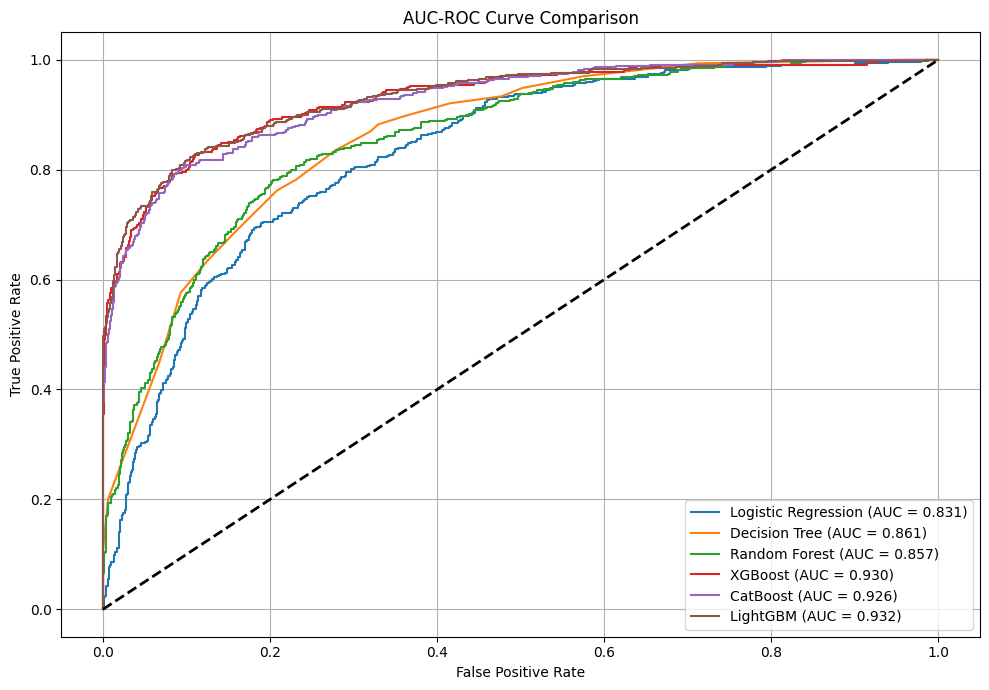

In [68]:
# AUC-ROC curve
# Get FPR, TPR for each model
fpr_log, tpr_log, _ = roc_curve(target_test, lr_proba)
fpr_dt, tpr_dt, _ = roc_curve(target_test, dt_proba)
fpr_rf, tpr_rf, _ = roc_curve(target_test, rf_proba)
fpr_xgb, tpr_xgb, _ = roc_curve(target_test, xgb_proba)
fpr_cat, tpr_cat, _ = roc_curve(target_test, cat_proba)
fpr_lgb, tpr_lgb, _ = roc_curve(target_test, lgb_proba)

# Plot
plt.figure(figsize=(10, 7))
plt.plot(fpr_log, tpr_log, label=f"Logistic Regression (AUC = {roc_auc_score(target_test, lr_proba):.3f})")
plt.plot(fpr_dt, tpr_dt, label=f"Decision Tree (AUC = {roc_auc_score(target_test, dt_proba):.3f})")
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {roc_auc_score(target_test, rf_proba):.3f})")
plt.plot(fpr_xgb, tpr_xgb, label=f"XGBoost (AUC = {roc_auc_score(target_test, xgb_proba):.3f})")
plt.plot(fpr_cat, tpr_cat, label=f"CatBoost (AUC = {roc_auc_score(target_test, cat_proba):.3f})")
plt.plot(fpr_lgb, tpr_lgb, label=f"LightGBM (AUC = {roc_auc_score(target_test, lgb_proba):.3f})")

# Diagonal line for reference
plt.plot([0, 1], [0, 1], 'k--', lw=2)

# Plot formatting
plt.title('AUC-ROC Curve Comparison')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

A variety of classification models were evaluated for their performance in predicting customer churn. The models were assessed using two key metrics: AUC-ROC (which measures the model's ability to distinguish between churn and non-churn classes) and Accuracy (the overall proportion of correctly classified instances). 
- LightGBM achieved the highest performance across both metrics, making it the top-performing model in this study.
- XGBoost and CatBoost also delivered excellent results, with AUC-ROC scores above 0.92 and accuracy above 88%, showing strong ability to generalize and capture patterns in the data.
- The Decision Tree and Random Forest models provided moderate performance, while still significantly outperforming a baseline model.
- Logistic Regression, while simple and interpretable, had the lowest scores, though it remains a strong benchmark model.

The AUC-ROC (Area Under the Receiver Operating Characteristic Curve) is a performance measurement for classification problems at various threshold settings. The ROC curve plots the True Positive Rate (Recall) against the False Positive Rate. The closer the ROC curve is to the top-left corner, the better the model is at correctly classifying positive and negative instances.
- LightGBM had the highest AUC (0.932), with its ROC curve closest to the top-left corner, indicating superior classification capability across different thresholds.
- XGBoost and CatBoost followed closely with AUC values of 0.930 and 0.926, respectively, also demonstrating excellent class separation.

From the above analysis, LightGBM is  best suited for this churn prediction task, offering both high accuracy and strong class separation (as indicated by AUC-ROC). Given its top scores and efficiency, LightGBM is recommended for deployment in a production environment.


<div class="alert alert-block alert-suc">
<b>Reviewer's comment</b> Very nice job here! Excellent job on this and congratulations. 
<a class="tocSkip"></


# Conclusion:
The goal of this project was to build a machine learning model capable of predicting customer churn for a telecom company. This helps in proactive customer retention strategies by identifying customers at risk of leaving the service.

The dataset was loaded and  gain an initial overview of the dataset, assess its structure and quality, and identify important patterns and potential issues. 
Before modeling, several important data preprocessing steps were performed to ensure data consistency, quality, and readiness for analysis:

- Merging Datasets: Multiple datasets were merged using the common identifier Customer ID, creating a unified dataset containing demographic, account, and service-related attributes for each customer.
- Handling Missing Values
- Type Conversions
- Define target variable: The target variable churn was defined as a binary classification outcome:
     - Churn = 1 for customers who discontinued the service
     - Churn = 0 for customers who remained
This binary target enabled the use of supervised classification algorithms for churn prediction.
These preparation steps were essential for ensuring data integrity and compatibility with machine learning algorithms. They also helped mitigate data quality issues that could impact model accuracy and reliability.

The EDA phase provided valuable  statistical insights into churn behavior:
- Churn Rate: ~26.58% of customers in the dataset have churned, indicating a moderate class imbalance. This imbalance was considered during modeling via class weighting and careful metric selection (e.g., AUC-ROC).
- Customer Demographics:
     - Senior citizens show notably higher churn across both genders.
     - Gender, however, does not significantly influence churn.
- Contract Type:
     - Month-to-month contracts exhibit the highest churn rate (42.7%).
     - In contrast, two-year contracts have a very low churn rate (2.8%), implying that longer-term customers are more likely to stay.
- Payment Methods:
     - Customers using electronic checks have the highest churn rate (45.3%).
     - Automatic payments (via bank transfer or credit card) correlate with significantly lower churn (15–20%), indicating financial convenience and automation reduce churn.
- Services
    - Lack of online security, tech support, and online backup is linked to higher churn. These services appear to have a retention effect, suggesting they increase customer stickiness.
- Charges and Tenure:
    - Churned customers tend to have lower total charges, likely due to shorter tenure.
    - Monthly charges are higher among churned customers, possibly due to being on month-to-month plans with more expensive add-ons.

Multiple machine learning models were trained, optimized, and evaluated using metrics focused on performance and class separation. 

- LightGBM outperformed all other models in both AUC-ROC and accuracy, making it the top choice for deployment.
- XGBoost and CatBoost also delivered strong performance, with AUC-ROC values above 0.92, showing excellent discrimination between churn and non-churn classes.
- Logistic regression, while less accurate, provided a valuable baseline and interpretability.

The LightGBM model demonstrated the best overall performance and is recommended for deployment to support churn mitigation strategies.